# Parameter Estimation on November 2018 #(Riding Service Dataset In Chicago)

Data Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
Ride_data= pd.read_csv('~/Desktop/Transportation_Network_Providers_-_Trips.csv')

In [ ]:
#pd.set_option('display.max_columns', None)
#Ride_data.head()

In [ ]:
#max(Ride_data['Trip Start Timestamp'])

In [ ]:
#min(Ride_data['Trip Start Timestamp'])

In [ ]:
#Ride_data.info()

In [ ]:
#Ride_data.describe().transpose()

In [ ]:
#Ride_data.isnull().sum()

In [ ]:
#len(Ride_data)

In [ ]:
#Ride_data['Trip ID'].nunique()

In [ ]:
#Ride_data['Shared Trip Authorized'].value_counts()

In [ ]:
#share_riding=Ride_data['Shared Trip Authorized'].value_counts()/len(Ride_data)
#share_riding=share_riding.to_frame().reset_index()
#share_riding=share_riding.rename(columns={"index": "Share Riding"})
#sns.barplot(x='Share Riding',y='Shared Trip Authorized',data=share_riding,palette="Spectral")

In [ ]:
#hot_sources=Ride_data.groupby(['Pickup Community Area']).count()['Trip ID'].sort_values(ascending=False).head(10)
#hot_sources=hot_sources.to_frame().reset_index()
#hot_sources=hot_sources.rename(columns={"Trip ID": "Frequency"})
#sns.barplot(x='Pickup Community Area',y='Frequency',data=hot_sources,palette="Spectral")

In [ ]:
#hot_dests=Ride_data.groupby(['Dropoff Community Area']).count()['Trip ID'].sort_values(ascending=False).head(10)
#hot_dests=hot_dests.to_frame().reset_index()
#hot_dests=hot_dests.rename(columns={"Trip ID": "Frequency"})
#sns.barplot(x='Dropoff Community Area',y='Frequency',data=hot_dests,palette="deep")

In [ ]:
#trips_pooled=Ride_data.groupby(['Trips Pooled']).count()['Trip ID']
#trips_pooled=trips_pooled.to_frame().reset_index()
#trips_pooled=trips_pooled.rename(columns={"Trips Pooled": "Size", "Trip ID": "Frequency"})
#sns.barplot(x='Size',y='Frequency',data=trips_pooled,palette="vlag")

In [ ]:
#sns.set_style('whitegrid')
#sns.distplot(Ride_data.Fare)

In [ ]:
#sns.set()
#sns.distplot(Ride_data['Trip Miles'])

-----

Data Pre-processing

In [3]:
sample_clean=Ride_data.dropna(subset=['Pickup Census Tract', 'Dropoff Census Tract']).reset_index()
sample_clean.drop(['index'],axis=1,inplace=True)

In [ ]:
#sample_clean.isnull().sum()

In [ ]:
#sample_clean.info()

In [ ]:
#sample_clean['Pickup Census Tract'].nunique()

In [ ]:
#sample_clean['Dropoff Census Tract'].nunique()

In [4]:
def is_weekend(day):
    if day in [6,7]:
        return 1
    else:
        return 0

In [5]:
def feature_extraction(riding):
    riding['Timestamp']    = pd.to_datetime(riding['Trip Start Timestamp'])
    riding['Date']         = riding['Timestamp'].dt.date
    riding['Hour']         = riding['Timestamp'].dt.hour
    riding['DayofWeek']    = riding['Timestamp'].dt.dayofweek
    riding['isWeekend']    = riding['DayofWeek'].apply(is_weekend)
    return riding

In [6]:
sample_clean=feature_extraction(sample_clean)
sample_clean['Date']=sample_clean['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

------

Price Analysis - November 10

In [ ]:
#riding_subset= sample_clean[sample_clean['Date']=='2018-11-10']

In [ ]:
#riding_subset['Pickup Census Tract'].nunique()

In [ ]:
#riding_subset['Dropoff Census Tract'].nunique()

In [ ]:
#riding_subset.groupby(['Pickup Census Tract','Dropoff Census Tract']).count()['Fare'].sort_values(ascending=False)

In [ ]:
#riding_subset_1=riding_subset.loc[(riding_subset.Hour>=0) & (riding_subset.Hour<7)] 

In [ ]:
#riding_subset_2=riding_subset.loc[(riding_subset.Hour>=7) & (riding_subset.Hour<10)]
#riding_subset_2.head()

In [ ]:
#riding_subset_3=riding_subset.loc[(riding_subset.Hour>=10) & (riding_subset.Hour<16)] 

In [ ]:
#riding_subset_4=riding_subset.loc[(riding_subset.Hour>=16) & (riding_subset.Hour<20)] 

In [ ]:
#riding_subset_5=riding_subset.loc[(riding_subset.Hour>=20) & (riding_subset.Hour<24)] 

In [ ]:
#exclusive_1=riding_subset_1[riding_subset_1['Shared Trip Authorized']==False].groupby(['Pickup Census Tract','Dropoff Census Tract']).mean()['Fare'].sort_values(ascending=False).reset_index()
#exclusive_1=pd.DataFrame(exclusive_1)
#exclusive_1.head()

In [ ]:
#shared_1=riding_subset_1[riding_subset_1['Shared Trip Authorized']==True].groupby(['Pickup Census Tract','Dropoff Census Tract']).mean()['Fare'].sort_values(ascending=False).reset_index()
#shared_1=pd.DataFrame(shared_1)
#shared_1.head()

----

Baseline Model - Price Estimation

In [7]:
def time_period(isWeekend,hour):
    if isWeekend==0:
        if hour in [0,1,2,3,4,5,6]:
             return 1
        elif hour in [7,8,9] :
             return 2
        elif hour in [10,11,12,13,14] :
             return 3
        elif hour in [15,16,17,18] :
             return 4
        else:
            return 5
    elif isWeekend==1:
        if hour in [0,1,2,3,4,5,6,7,8,9]:
             return 1
        elif hour in [10,11,12,13,14,15,16]:
             return 2   
        else:
             return 3

In [8]:
sample_clean['Period']=sample_clean.apply(lambda x: time_period(x['isWeekend'], x['Hour']), axis=1)

In [9]:
day_list     = list(sample_clean.Date.unique())
day_period   = list(sample_clean.Period.unique())
df_shared    = {}
df_exclusive = {}
for d in day_list :
    for p in day_period :
        df_day_period           = sample_clean.loc[(sample_clean.Date==d) & (sample_clean.Period==p)]
        df_shared    [d,p] = df_day_period[df_day_period['Shared Trip Authorized']==True].groupby(['Pickup Census Tract','Dropoff Census Tract']).mean()['Fare'].sort_values(ascending=False).reset_index()
        df_exclusive [d,p] = df_day_period[df_day_period['Shared Trip Authorized']==False].groupby(['Pickup Census Tract','Dropoff Census Tract']).mean()['Fare'].sort_values(ascending=False).reset_index()

In [10]:
nrow=len(df_shared.keys())
df_shr=pd.DataFrame()
for i in range(nrow):
    df_inter=df_shared[list(df_shared.keys())[i]]
    df_inter=df_inter.assign(Date=list(df_shared.keys())[i][0])
    df_inter=df_inter.assign(Period=list(df_shared.keys())[i][1])
    df_shr=df_shr.append(df_inter)

In [11]:
df_shr = df_shr.assign(Trip_Authorized=False)

In [12]:
nrow=len(df_exclusive.keys())
df_exc=pd.DataFrame()
for i in range(nrow):
    df_inter=df_exclusive[list(df_exclusive.keys())[i]]
    df_inter=df_inter.assign(Date=list(df_exclusive.keys())[i][0])
    df_inter=df_inter.assign(Period=list(df_exclusive.keys())[i][1])
    df_exc=df_exc.append(df_inter)

In [13]:
df_exc = df_exc.assign(Trip_Authorized=True)

In [14]:
est_riding=pd.concat([df_exc,df_shr],axis=0)

In [15]:
pd.set_option('display.max_columns', None)
upd_riding_data=pd.merge(left=sample_clean, right=est_riding, left_on=['Pickup Census Tract','Dropoff Census Tract','Date','Period','Shared Trip Authorized'], right_on=['Pickup Census Tract','Dropoff Census Tract','Date','Period','Trip_Authorized'],how='inner')

In [16]:
final_data=upd_riding_data[['Trip ID','Date','Period','Pickup Census Tract','Dropoff Census Tract','Shared Trip Authorized','Fare_x','Fare_y']]
#final_data.head()

In [17]:
final_data=final_data.rename(columns={"Fare_x": "Fare", "Fare_y": "Estimated price_other option"})

-------

Baseline Model - Performance

In [ ]:
#shared_per=len(final_data[(final_data['Shared Trip Authorized']==True) & (final_data['Estimated price_other option']>final_data.Fare)])/ len(final_data[final_data['Shared Trip Authorized']==True])
#round(shared_per,3)

In [ ]:
#exclusive_per=len(final_data[(final_data['Shared Trip Authorized']==False) & (final_data.Fare>final_data['Estimated price_other option'])])/ len(final_data[final_data['Shared Trip Authorized']==False])
#round(exclusive_per,3)

-----

Save Price Estimation Of Baseline Model

In [ ]:
#final_data.to_csv('Final Table.csv',index=False)

-----

Validation - Sample in Excel

In [ ]:
#trial=sample_clean[(sample_clean.Date=='2018-11-10') & (sample_clean.Period==3)]

In [ ]:
#trial['Shared Trip Authorized'].value_counts()

In [ ]:
#trial.to_csv('Left Join Data.csv',index=False)

In [ ]:
#subset=est_dist[(est_dist.Date=='2018-11-10') & (est_dist.Period==3)]

In [ ]:
#len(subset)

In [ ]:
#subset.to_csv('Right Join Data.csv',index=False)

In [ ]:
#upd=upd_dist_data[(upd_dist_data.Date=='2018-11-10') & (upd_dist_data.Period==3)]

In [ ]:
#last_table=upd_dist_data[(upd_dist_data.Date=='2018-11-10') & (upd_dist_data.Period==3)]

In [ ]:
#last_table.to_csv('Combined.csv',index=False)

In [ ]:
#last_subset=pd.DataFrame(trial.groupby(['Pickup Census Tract','Dropoff Census Tract']).count()['Trip ID'].sort_values(ascending=False)).reset_index()

In [ ]:
#last_subset['Pickup Census Tract'][0]

In [ ]:
#last_subset['Dropoff Census Tract'][0]

--------

Baseline Model - Distance Estimation

In [ ]:
#day_list     = list(sample_clean.Date.unique())
#day_period   = list(sample_clean.Period.unique())
#df_share    = {}
#df_exclusiv = {}
#for d in day_list :
    #for p in day_period :
        #df_day_per           = sample_clean.loc[(sample_clean.Date==d) & (sample_clean.Period==p)]
        #df_share    [d,p] = df_day_per[df_day_per['Shared Trip Authorized']==True].groupby(['Pickup Census Tract','Dropoff Census Tract']).mean()['Trip Miles'].sort_values(ascending=False).reset_index()
        #df_exclusiv [d,p] = df_day_per[df_day_per['Shared Trip Authorized']==False].groupby(['Pickup Census Tract','Dropoff Census Tract']).mean()['Trip Miles'].sort_values(ascending=False).reset_index()

In [ ]:
#nrow=len(df_share.keys())
#df_shr_dist=pd.DataFrame()
#for i in range(nrow):
    #df_inter=df_share[list(df_share.keys())[i]]
    #df_inter=df_inter.assign(Date=list(df_share.keys())[i][0])
    #df_inter=df_inter.assign(Period=list(df_share.keys())[i][1])
    #df_shr_dist=df_shr_dist.append(df_inter)
#df_shr_dist = df_shr_dist.assign(Trip_Authorized=False)

In [ ]:
#nrow=len(df_exclusiv.keys())
#df_exc_dist=pd.DataFrame()
#for i in range(nrow):
    #df_inter=df_exclusiv[list(df_exclusiv.keys())[i]]
    #df_inter=df_inter.assign(Date=list(df_exclusiv.keys())[i][0])
    #df_inter=df_inter.assign(Period=list(df_exclusiv.keys())[i][1])
    #df_exc_dist=df_exc_dist.append(df_inter)
#df_exc_dist = df_exc_dist.assign(Trip_Authorized=True)

In [ ]:
#est_dist=pd.concat([df_exc_dist,df_shr_dist],axis=0)

In [ ]:
#pd.set_option('display.max_columns', None)
#upd_dist_data=pd.merge(left=sample_clean, right=est_dist, left_on=['Pickup Census Tract','Dropoff Census Tract','Date','Period','Shared Trip Authorized'], right_on=['Pickup Census Tract','Dropoff Census Tract','Date','Period','Trip_Authorized'],how='inner')
#upd_dist_data=upd_dist_data.rename(columns={'Trip Miles_x':'Actual','Trip Miles_y':'Estimated'})
#upd_dist_data.head()

In [ ]:
#shared_dist_per=len(upd_dist_data[(upd_dist_data['Shared Trip Authorized']==True) & (upd_dist_data['Estimated']<upd_dist_data.Actual)])/ len(upd_dist_data[upd_dist_data['Shared Trip Authorized']==True])
#round(shared_dist_per,3)

In [ ]:
#exclusive_dist_per=len(upd_dist_data[(upd_dist_data['Shared Trip Authorized']==False) & (upd_dist_data.Actual<upd_dist_data['Estimated'])])/ len(upd_dist_data[upd_dist_data['Shared Trip Authorized']==False])
#round(exclusive_dist_per,3)

In [ ]:
#def add_dist(dataset):
    #if dataset['Shared Trip Authorized']==True:
        #AdditionDistance=dataset.Actual-dataset.Estimated
        #return AdditionDistance
    #else:
        #AdditionDistance=dataset.Estimated-dataset.Actual
        #return AdditionDistance

In [ ]:
#upd_dist_data['AdditionDistance'] = upd_dist_data[['Shared Trip Authorized','Actual','Estimated']].apply (lambda row: add_dist(row), axis=1)
#upd_dist_data.head()

-----

Updated Distance Model

In [18]:
from math import radians, cos, sin, asin, sqrt 
def distance(lat1, lat2, lon1, lon2): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 3956
       
    # calculate the result 
    return(c * r) 

In [19]:
sample_riding=sample_clean.copy()
#sample_riding.head()

In [20]:
def dist(dataset):
    if dataset['Shared Trip Authorized']==False:
        EstDistance=dataset['Trip Miles']*1.3
        return EstDistance
    else:
        EstDistance=distance(dataset['Pickup Centroid Longitude'],dataset['Dropoff Centroid Longitude'],dataset['Pickup Centroid Latitude'],dataset['Dropoff Centroid Latitude'])
        return EstDistance

In [21]:
sample_riding['EstDistance'] = sample_riding[['Shared Trip Authorized','Trip Miles','Pickup Centroid Longitude','Dropoff Centroid Longitude','Pickup Centroid Latitude','Dropoff Centroid Latitude']].apply(lambda row: dist(row), axis=1)

In [ ]:
#pd.set_option('display.max_columns', None)
#sample_riding.head()

In [ ]:
#shared_dist_up=len(sample_riding[(sample_riding['Shared Trip Authorized']==True) & (sample_riding['EstDistance']<sample_riding['Trip Miles'])])/ len(sample_riding[sample_riding['Shared Trip Authorized']==True])
#round(shared_dist_up,3)

In [ ]:
#exclusive_dist_up=len(sample_riding[(sample_riding['Shared Trip Authorized']==False) & (sample_riding['Trip Miles']<sample_riding['EstDistance'])])/ len(sample_riding[sample_riding['Shared Trip Authorized']==False])
#round(exclusive_dist_up,3)

-------

Updated Price Model

In [22]:
day_list     = list(sample_clean.Date.unique())
day_period   = list(sample_clean.Period.unique())
df_shared_dist    = {}
df_exclusive_dist = {}
for d in day_list :
    for p in day_period :
        df_day_period           = sample_clean.loc[(sample_clean.Date==d) & (sample_clean.Period==p)]
        df_shared_dist    [d,p] = df_day_period[df_day_period['Shared Trip Authorized']==True].groupby(['Pickup Census Tract','Dropoff Census Tract']).mean()['Trip Miles'].sort_values(ascending=False).reset_index()
        df_exclusive_dist [d,p] = df_day_period[df_day_period['Shared Trip Authorized']==False].groupby(['Pickup Census Tract','Dropoff Census Tract']).mean()['Trip Miles'].sort_values(ascending=False).reset_index()

In [23]:
nrow=len(df_shared_dist.keys())
df_shr_distance=pd.DataFrame()
for i in range(nrow):
    df_inter=df_shared_dist[list(df_shared_dist.keys())[i]]
    df_inter=df_inter.assign(Date=list(df_shared_dist.keys())[i][0])
    df_inter=df_inter.assign(Period=list(df_shared_dist.keys())[i][1])
    df_shr_distance=df_shr_distance.append(df_inter)

In [24]:
df_shr_distance= df_shr_distance.assign(Trip_Authorized=False)

In [25]:
nrow=len(df_exclusive_dist.keys())
df_exc_distance=pd.DataFrame()
for i in range(nrow):
    df_inter=df_exclusive_dist[list(df_exclusive_dist.keys())[i]]
    df_inter=df_inter.assign(Date=list(df_exclusive_dist.keys())[i][0])
    df_inter=df_inter.assign(Period=list(df_exclusive_dist.keys())[i][1])
    df_exc_distance=df_exc_distance.append(df_inter)

In [26]:
df_exc_distance = df_exc_distance.assign(Trip_Authorized=True)

In [27]:
pd.set_option('display.max_columns', None)
df_exc_combined=pd.merge(left=df_exc, right=df_exc_distance, left_on=['Pickup Census Tract','Dropoff Census Tract','Date','Period'], right_on=['Pickup Census Tract','Dropoff Census Tract','Date','Period'],how='inner')
df_exc_combined=df_exc_combined.drop(['Trip_Authorized_y'],axis=1)
df_exc_combined=df_exc_combined.rename(columns={'Trip_Authorized_x':'Trip_Authorized'})
df_exc_combined['Price_per_mile']=df_exc_combined['Fare']/df_exc_combined['Trip Miles']

In [28]:
pd.set_option('display.max_columns', None)
df_shr_combined=pd.merge(left=df_shr, right=df_shr_distance, left_on=['Pickup Census Tract','Dropoff Census Tract','Date','Period'], right_on=['Pickup Census Tract','Dropoff Census Tract','Date','Period'],how='inner')
df_shr_combined=df_shr_combined.drop(['Trip_Authorized_y'],axis=1)
df_shr_combined=df_shr_combined.rename(columns={'Trip_Authorized_x':'Trip_Authorized'})
df_shr_combined['Price_per_mile']=df_shr_combined['Fare']/df_shr_combined['Trip Miles']

In [29]:
est_riding_combined=pd.concat([df_exc_combined,df_shr_combined],axis=0)

In [30]:
pd.set_option('display.max_columns', None)
upd_combined_riding_data=pd.merge(left=sample_clean, right=est_riding_combined, left_on=['Pickup Census Tract','Dropoff Census Tract','Date','Period','Shared Trip Authorized'], right_on=['Pickup Census Tract','Dropoff Census Tract','Date','Period','Trip_Authorized'],how='inner')

In [31]:
upd_combined_riding_data['EstPrice']=upd_combined_riding_data['Price_per_mile']*upd_combined_riding_data['Trip Miles_x']

In [32]:
upd_price_data=upd_combined_riding_data[['Trip ID','Trip Start Timestamp','Trip End Timestamp','Trip Seconds','Trip Miles_x','Pickup Census Tract','Dropoff Census Tract','Fare_x','Shared Trip Authorized','Trips Pooled','Date','Hour','DayofWeek','isWeekend','Period','EstPrice']]

In [33]:
final_upd_data=upd_combined_riding_data[['Trip ID','Date','Period','Pickup Census Tract','Dropoff Census Tract','Shared Trip Authorized','Fare_x','EstPrice']]
final_upd_data=final_upd_data.rename(columns={"Fare_x": "Fare", "EstPrice": "Estimated price_other option"})
#final_upd_data.head()

-------------

Save Price Estimation of Updated Price Model

In [ ]:
#final_upd_data.to_csv('Final Table_updated.csv',index=False)

---

Updated Price Model - Performance

In [ ]:
#upd_shared_per=len(final_upd_data[(final_upd_data['Shared Trip Authorized']==True) & (final_upd_data['Estimated price_other option']>final_upd_data.Fare)])/ len(final_upd_data[final_upd_data['Shared Trip Authorized']==True])
#round(upd_shared_per,3)

In [ ]:
#upd_exclusive_per=len(final_upd_data[(final_upd_data['Shared Trip Authorized']==False) & (final_upd_data.Fare>final_upd_data['Estimated price_other option'])])/ len(final_upd_data[final_upd_data['Shared Trip Authorized']==False])
#round(upd_exclusive_per,3)

-----

Final Table and Feature Engineering

In [74]:
riding_dist=sample_riding[['Trip ID','EstDistance']]

In [75]:
pd.set_option('display.max_columns', None)
final_combined=pd.merge(left=upd_price_data, right=riding_dist, left_on=['Trip ID'], right_on=['Trip ID'],how='inner')

In [76]:
final_combined=final_combined.rename(columns={'Fare_x':'Actual Price','Trip Miles_x':'Trip Miles'})

In [77]:
#final_combined.head()

In [78]:
len(final_combined)

3060271

In [79]:
def ratio(dataset):
    if dataset['Shared Trip Authorized']==False:
        AddDist=(dataset.EstDistance-dataset['Trip Miles'])/dataset['Trip Miles']
        return AddDist
    else:
        AddDist=(dataset['Trip Miles']-dataset.EstDistance)/dataset['EstDistance']
        return AddDist

In [80]:
len(final_combined[final_combined['Trip Miles']==0])

0

In [81]:
len(final_combined[final_combined['EstDistance']==0])

0

In [82]:
final_combined=final_combined[~(final_combined['Trip Miles']==0)]
final_combined=final_combined[~(final_combined['EstDistance']==0)]

In [83]:
final_combined['AddDistance'] = final_combined[['Shared Trip Authorized','Trip Miles','EstDistance']].apply(lambda row: ratio(row), axis=1)

In [84]:
len(final_combined[final_combined['AddDistance']<0])

0

In [85]:
final_combined=final_combined[~(final_combined['AddDistance']<0)]

In [86]:
len(final_combined)

3060271

In [87]:
def feature(dataset):
    if dataset['Shared Trip Authorized']==False:
        NewDist=dataset['Trip Miles']
        return NewDist
    else:
        NewDist=dataset['EstDistance']
        return NewDist

In [88]:
final_combined['NewAtt_1'] = final_combined[['Shared Trip Authorized','Trip Miles','EstDistance']].apply(lambda row: feature(row), axis=1)

In [89]:
final_combined['NewAtt_2']=final_combined['AddDistance']*final_combined['NewAtt_1']

In [90]:
final_combined['NewAtt_3']= - final_combined['NewAtt_1']

In [92]:
final_combined=final_combined[~(final_combined.isnull(). any(axis=1))]

------

Validation of Exclusive vs Shared Service

In [ ]:
#deneme=final_combined[(final_combined['Shared Trip Authorized']) & (final_combined['Trips Pooled']==1)]

In [ ]:
#len(deneme)

In [ ]:
#zero_data=final_combined[final_combined['Actual Price']==0]

In [ ]:
#zero_data.head()

In [ ]:
#len(zero_data)

In [ ]:
#case=final_combined[(final_combined['Pickup Census Tract']==17031839100) & (final_combined['Dropoff Census Tract']==17031330100)]

------

Splitting data into train and test

In [93]:
def output(dataset):
    if dataset['Shared Trip Authorized']==False:
        Class=0
        return Class
    else:
        Class=1
        return Class

In [94]:
final_combined['Class'] = final_combined[['Shared Trip Authorized']].apply(lambda row: output(row), axis=1)

In [95]:
len(final_combined)

3058560

In [96]:
X=final_combined[['NewAtt_1','NewAtt_2','NewAtt_3']]

In [97]:
y=final_combined['Class']

In [98]:
from sklearn.model_selection import train_test_split

In [101]:
X_train.head()

,NewAtt_1,NewAtt_2,NewAtt_3
2869104,2.900000,0.870000,-2.900000
1766665,0.257333,1.042667,-0.257333
2926806,1.000000,0.300000,-1.000000
2087234,17.600000,5.280000,-17.600000
2204151,1.600000,0.480000,-1.600000


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

------

Implement Logistic Regression model

In [102]:
from sklearn.linear_model import LogisticRegression

In [103]:
logmodel = LogisticRegression()

In [104]:
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [134]:
parameters= logmodel.coef_
parameters

array([[-0.51535291,  3.0436928 ,  0.51535291]])

In [132]:
intercept=logmodel.intercept_
intercept

array([-1.77385263])

--------

Evaluate performance of the model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

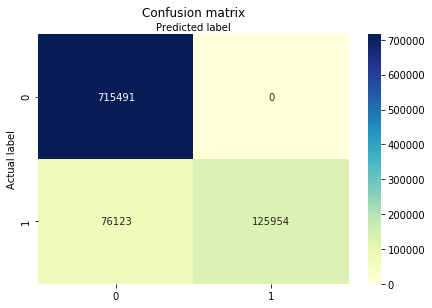

In [121]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [127]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))

Accuracy: 0.9170383012485178
Precision: 1.0
Recall: 0.6232970600315721
